In [3130]:
import re
import imaplib
import email
import base64
from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from email.header import decode_header
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.cache_size = 2000  # Увеличить лимит кэшированных объектов до 2к

pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [3131]:
username = "nikolaev3ndriu@yandex.ru"
pswd = "owthutrlcjlixisk"
imap_server = "imap.yandex.ru"

imap = imaplib.IMAP4_SSL(imap_server)
print(imap.login(username, pswd))
print(imap.select("INBOX"))

('OK', [b'LOGIN Completed.'])
('OK', [b'13416'])


In [3132]:
result, data = imap.search(None, 'FROM "no-reply@support-uber.com"')
msg_ids = (data[0].split())

list_of_dates = []
list_of_trips = []
list_if_id_trips = []

for msg_id in msg_ids:
    result, list_data = imap.fetch(msg_id, 'RFC822')
    msg = email.message_from_bytes(list_data[0][1])
    id_trip = msg_id.decode('utf-8')
    list_if_id_trips.append(id_trip)
    subject = msg.get("Subject")
    decoded_parts = decode_header(subject)
    subject_str = ''.join(part.decode(enc or 'utf-8') if isinstance(part, bytes) else part for part, enc in decoded_parts)
    match = re.search(r'(\d{1,2}) ([а-яА-Я]+) (\d{4})', subject_str)
    if match:
        day, month_str, year = match.groups()
        months = {
                'января': '01', 'февраля': '02', 'марта': '03', 'апреля': '04', 'мая': '05', 'июня': '06', 'июля': '07', 'августа': '08',
                'сентября': '09', 'октября': '10', 'ноября': '11', 'декабря': '12'
                }
        month = months[month_str]
        date_str = f"{day}.{month}.{year}"
        date = pd.to_datetime(date_str, format='%d.%m.%Y')
        list_of_dates.append(date)
    else:
        list_of_dates.append(None)
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            html_bytes = part.get_payload(decode=True)
            charset = part.get_content_charset() or 'utf-8'
            html_str = html_bytes.decode(charset, errors='replace')
            soup = BeautifulSoup(html_str, 'html.parser')
            tag = soup.body
            cleaned = [s.strip() for s in tag.stripped_strings if s.strip()][0:21] # 21 тк разная форма отчетов
            list_of_trips.append(cleaned)
            
df = pd.DataFrame(list_of_trips)
df['id_trips'] = list_if_id_trips
df["date"] = list_of_dates
df["date"] = pd.to_datetime(df["date"])
df = df.drop(0, axis = 0) # удаляем письмо с подтверждением подписки на отчеты

In [3133]:
columns = (["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", '18', "19", "20", "id_trips", "date"])
df.columns = columns

In [3134]:
df["date"].dt.year.value_counts()

2023    75
2022    60
2024    46
2021    19
2025     9
Name: date, dtype: int64

#### За 5 ле использования Uber поменял формат/структуру отчетов о поездках, поэтому в итоговом df после парсинга некоторые значения съехали в другие столбцы
1. 62 отмененые поездеи

- Оплата - карта
- Наличные - наличка
- СПБ - СПБ

In [3135]:
df.sample(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,id_trips,date
178,13:13,Место посадки,13:29,"улица Богдана Хмельницкого, 117к1",155 ₽,Тариф,UberX,Общая стоимость,155 ₽,Способ оплаты\n ...,155 ₽,Получатель платежа,ИП Медаков Валерий Федорович,Водитель:,Васильев Олег Эдуардович,чёрный Chevrolet Klan J200,К435УН21,Перевозчик,Партнёр: ИП Медаков Валерий Федорович,+79370105855,Забыли вещи в машине или другой вопрос по поез...,7550,2024-03-16
22,19:23,"Авиамоторная улица, 55к31",19:27,"Авиамоторная улица, 43/24",149 ₽,Тариф,UberX,Стоимость,149 ₽,Оплата,****1873,149 ₽,Водитель: Сариев Темирлан Муратбекович,жёлтый Hyundai Solaris,РР45377,"Партнёр: ООО ""АВКАРС"", ОГРН 1205000023645",+74952155459,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1501,2022-06-26
188,01:21,"улица Гарибальди, 1А",01:49,"Ильинский бульвар, 8",944 ₽,Тариф,UberX,Общая стоимость,944 ₽,Способ оплаты\n ...,944 ₽,Получатель платежа,"ООО ""УК МАРМАГ""",Водитель:,Тагиров Кимран Касумович,жёлтый Volkswagen Polo,М878КК797,Перевозчик,"Партнёр: ООО ""УК МАРМАГ""",+74951444414,Забыли вещи в машине или другой вопрос по поез...,13289,2024-04-02
57,14:00,"улица Спиридона Михайлова, 1",14:06,"проспект Максима Горького, 21",96 ₽,Тариф,UberX,Стоимость,96 ₽,Оплата,****3154,96 ₽,Водитель: Васильев Андрей Геннадьевич,коричневый Datsun on-DO,К384ОК21,"Партнёр: ИП Алексеев Илья Владимирович, ОГРН 3...",+79373877771,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1536,2021-11-06
203,02:37,"улица Вавилова, 81",03:22,"Ильинский бульвар, 8",1137 ₽,Тариф,Share,Общая стоимость,1137 ₽,Способ оплаты\n ...,1137 ₽,Получатель платежа,ИП Царьков Михаил Артурович,Водитель:,Алимов Холмурод Равшанбек Угли,белый Kia Rio,А100ТН790,Перевозчик,Партнёр: ИП Царьков Михаил Артурович,+79629099888,Забыли вещи в машине или другой вопрос по поез...,13304,2025-02-23


In [3136]:
df_base_with_tariff = df[df["5"] == "Тариф"].copy()

df_base_with_tariff = df_base_with_tariff.drop(["4", "5", "7"], axis=1)
df_base_with_tariff["9"] = df_base_with_tariff['9'].apply(lambda k: k.split()[-1].replace("(СБП)", "СПБ"))
mask = ~df_base_with_tariff['10'].str.contains('₽')
df_base_with_tariff["10"] = df_base_with_tariff["10"].where(mask, np.nan)

df_base_with_tariff["11"].value_counts() # показалась запись Водитель: Корнилов Денис Геннадьевич, которая там не должна быть - c 11 колонки начинается смещение записей 
check = df_base_with_tariff[df_base_with_tariff["11"] == "Водитель: Корнилов Денис Геннадьевич"] # решил сдвинуть значения ячеек вправо на 1 шаг, чтобы не сломать логику 

cols_for_33 = ['11', '12', '13', '14', '15', '16'] # для 33 индекса сдвинули вправо на 1 все ячейки начиная с 11-16
row_idx = 33
original = [df_base_with_tariff.at[row_idx, col] for col in cols_for_33] # текущие значения в этих ячейках
shifted = [''] + original[:-1] # добавил в начало пустую запись в ячейку, а из конца наоборот убрал
for col, value in zip(cols_for_11, shifted):
    df_base_with_tariff.at[row_idx, col] = value
    
df_base_with_tariff = df_base_with_tariff.drop("11", axis=1) # после мува ячеек вправо удалил 11 колонку, тк она не важна 
df_base_with_tariff.shape

(147, 19)

In [3137]:
# 1 df (0 - 73) ************************************************************************************************************************************************************************    

df_do_136 = df_base_with_tariff.loc[:73]
df_do_136.shape

(73, 19)

In [3138]:
# нужно подготовить df_net_poluchatel_platezha
df_est_poluchatel_platezha = df_base_with_tariff[(df_base_with_tariff["12"] == "Получатель платежа")]#.drop("11", axis=1) # здесь всего 33 записи

from_cols = ["15", "16", "17", "19", "20"]
to_cols = [str(i) for i in range(12, 17)]
for to_col, from_col in zip(to_cols, from_cols):
    df_est_poluchatel_platezha[to_col] = df_est_poluchatel_platezha[from_col]

# 2 df (136 - 146) ************************************************************************************************************************************************************************    
df_est_poluchatel_platezha.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(11, 19)

In [3139]:
df_net_poluchatel_platezha = df_base_with_tariff[(df_base_with_tariff["12"] != "Получатель платежа")]
df_net_poluchatel_platezha = df_net_poluchatel_platezha.loc[147:]

from_cols = ["14", "15", "16", "18", "19"]
to_cols = ["12", "13", "14", "15", "16"]
for to_col, from_col in zip(to_cols, from_cols):
    df_net_poluchatel_platezha[to_col] = df_net_poluchatel_platezha[from_col]
    
# 3 df (147 - end) ************************************************************************************************************************************************************************
df_net_poluchatel_platezha.shape

(63, 19)

In [3140]:
# итоговая таблица, которая содержит 147 записей с успешными поездками (оставшиеся - не успешные (62), тк были не начаты даже - отмененные)

df_new_original_147 = pd.concat([df_do_136, df_est_poluchatel_platezha, df_net_poluchatel_platezha], ignore_index=True)
df_new_original_147.head()

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
0,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1477,2022-09-06
1,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1478,2022-09-06
2,20:27,"улица Богдана Хмельницкого, 117к1",20:44,"Социалистическая улица, 7к2",UberX,182 ₽,Оплата,****1873,Водитель: Эргашев Акбарали Соатович,белый Chevrolet Cobalt,Е347РО21,Партнёр: Эргашев Акбарали Соатович,+79603040812,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1482,2022-08-20
3,11:33,"улица Богдана Хмельницкого, 117к1",11:40,"улица Юрия Гагарина, 22А",UberX,76 ₽,Оплата,****1873,Водитель: Николаев Владимир Леонидович,серый Granta,К504НР21,"Партнёр: ИП Пучков Иван Александрович, ОГРН 32...",+79003301600,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1483,2022-05-27
4,12:05,"проспект Максима Горького, 11",12:17,"улица Богдана Хмельницкого, 117к1",UberX,125 ₽,Оплата,****1873,Водитель: Яковлев Игорь Константинович,серый Volkswagen Polo,М715КМ152,"Партнёр: ИП Медаков Валерий Федорович, ОГРН 31...",+79370105855,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1484,2022-08-19


In [3141]:
# df с отмененными поездками (их нужно будет склеить с df_new_original_147)  8 9 10 12 15 16 - nan | 17 18 19 колонки проставить nan

df_base_not_tariff = df[df["5"] != "Тариф"].copy()
df_base_not_tariff = df_base_not_tariff.drop("4", axis=1)

from_cols = ["5", "6", "7", "8", "9"]
to_cols = ["6", "9", "13", "14", "16"]
for to_col, from_col in zip(to_cols, from_cols):
    df_base_not_tariff[to_col] = df_base_not_tariff[from_col]
    
df_base_not_tariff = df_base_not_tariff.drop(["5", "7", "11"], axis=1)
df_base_not_tariff[["8", "9", "10", "12", "15", "16"]] = np.nan
df_base_not_tariff.sample(n=4)

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
101,06:53,"Авиамоторная улица, 55к31",06:58,"Авиамоторная улица, 43/24",UberX,NaN,NaN,NaN,NaN,жёлтый Kia Rio,А951УР777,NaN,NaN,None,None,None,None,3148,2023-03-15
132,17:25,"улица Богдана Хмельницкого, 117к1",17:36,Место посадки,UberX,NaN,NaN,NaN,NaN,белый Volkswagen Polo,Н280КА21,NaN,NaN,None,None,None,None,5096,2023-09-03
87,09:09,"улица Богдана Хмельницкого, 117к1",09:19,Покровско-Татианинский собор,UberX,NaN,NaN,NaN,NaN,красный Granta,Е982НР21,NaN,NaN,None,None,None,None,2573,2023-01-08
75,15:23,"Авиамоторная улица, 55к31",15:27,"Авиамоторная улица, 43/24",UberX,NaN,NaN,NaN,NaN,жёлтый Skoda Rapid,В790ЕЕ797,NaN,NaN,None,None,None,None,1850,2022-11-05


In [3142]:
# df с котором можно уже работать

df_total = pd.concat([df_base_not_tariff, df_new_original_147], ignore_index=True)
df_total = df_total.drop(["17", "18", "19", "20"], axis=1)

new_columns = (["start_time", "a_point", "end_time", "b_point", "tariff", "cost", "payment_method", "card", "driver", "auto", "auto_number", "transporter", "telephone", "id_trips", "date"])
df_total.columns = new_columns
df_total

# мув колонки с ид в самое начало

first_column = df_total.pop('id_trips')
df_total.insert(0, 'id_trips', first_column)
df_total.sample(n=10)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date
137,5804,08:23,"улица Э.М. Юрьева, 1А",08:35,"улица Богдана Хмельницкого, 117к1",UberX,227 ₽,Наличные,•••• 1873,Яковлев Альберт Сергеевич,белый Granta,М909СК21,Партнёр: Яковлев Альберт Сергеевич,+79530108497,2023-11-05
155,6598,06:41,"улица Афанасьева, 8",06:51,"улица Богдана Хмельницкого, 117к1",Select,396 ₽,Наличные,NaN,Соловьев Даниил Вадимович,жёлтый Skoda Octavia,К134РУ21,Партнёр: ИП Костин Евгений Михайлович,+79651153553,2024-01-01
10,2561,14:13,"улица Богдана Хмельницкого, 117к1",14:28,"улица Ленинского Комсомола, 12",UberX,NaN,NaN,NaN,NaN,белый Vesta,У001АО21,NaN,NaN,2023-01-06
67,1485,15:24,"улица Богдана Хмельницкого, 117к1",15:32,"улица Карла Маркса, 31",UberX,249 ₽,Оплата,****1873,Водитель: Плисов Арнольд Михайлович,чёрный Kalina,В183РУ21,"Партнёр: ООО ""ТАКСИ САН-ДОР"", ОГРН 1182130008125",+79153868216,2022-07-24
71,1489,20:26,"улица Богдана Хмельницкого, 117к1",20:39,Железнодорожный вокзал,UberX,108 ₽,Оплата,****1873,Водитель: Кириллов Михаил Николаевич,белый Granta,К111НС21,"Партнёр: ООО ""РАУТ"", ОГРН 1062130001779",+79520281468,2022-06-29
83,1501,19:23,"Авиамоторная улица, 55к31",19:27,"Авиамоторная улица, 43/24",UberX,149 ₽,Оплата,****1873,Водитель: Сариев Темирлан Муратбекович,жёлтый Hyundai Solaris,РР45377,"Партнёр: ООО ""АВКАРС"", ОГРН 1205000023645",+74952155459,2022-06-26
3,2262,10:24,"Авиамоторная улица, 55к31",10:29,"Авиамоторная улица, 43/24",UberX,NaN,NaN,NaN,NaN,белый Kia Rio,А177ЕТ797,NaN,NaN,2022-12-13
114,1532,13:47,"улица Богдана Хмельницкого, 117к1",13:55,"Московский проспект, 21",UberX,83 ₽,Оплата,****3154,Водитель: Галкин Алексей Николаевич,белый Datsun on-DO,К733УК21,"Партнёр: ИП Емелин В Ю, ОГРН 321213000007045",+79083094745,2021-11-06
57,5066,09:04,"улица Юлиуса Фучика, 48А",09:12,"проспект Максима Горького, 24",UberX,NaN,NaN,NaN,NaN,красный Kia Cee'd,К046МВ21,NaN,NaN,2023-09-01
78,1496,14:25,"улица Бориса Семёновича Маркова, 16",14:31,"улица Богдана Хмельницкого, 117к1",UberX,73 ₽,Оплата,****1873,Водитель: Кузьмин Андрей Александрович,серый Granta,К791ТХ21,"Партнёр: ИП Емелин В Ю, ОГРН 321213000007045",+79083094745,2022-07-29


In [3143]:
# Преобразование типов данных

df_total[["tariff", "payment_method"]] = df_total[["tariff", "payment_method"]].astype("category")
df_total["cost"] = df_total["cost"].apply(lambda x: int(str(x).replace('₽', '').replace('\u202f', '').replace(' ', '')) if pd.notnull(x) else None)
df_total["start_time"] = pd.to_datetime(df_total["start_time"], format="%H:%M").dt.time
df_total["end_time"] = pd.to_datetime(df_total["end_time"], format='%H:%M').dt.time
df_total["driver_hash"] = df_total["driver"].apply(hash)

In [3144]:
def time_diff_minutes(t1, t2):
    m1 = t1.hour * 60 + t1.minute
    m2 = t2.hour * 60 + t2.minute
    diff = m2 - m1
    if diff < 0:  # если был переход через полночь
        diff += 24 * 60
    return diff  # только количество минут, целое число

df_total['in_time'] = [time_diff_minutes(s, e) for s, e in zip(df_total['start_time'], df_total['end_time'])]
df_total.sample(n=5)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date,driver_hash,in_time
118,1536,14:00:00,"улица Спиридона Михайлова, 1",14:06:00,"проспект Максима Горького, 21",UberX,96.0,Оплата,****3154,Водитель: Васильев Андрей Геннадьевич,коричневый Datsun on-DO,К384ОК21,"Партнёр: ИП Алексеев Илья Владимирович, ОГРН 3...",+79373877771,2021-11-06,-6163994847487758948,6
185,13287,23:37:00,"улица Богдана Хмельницкого, 117к1",23:50:00,V-lounge,UberX,173.0,СПБ,NaN,Яковлев Денис Юрьевич,серый Datsun on-DO,Н069КК21,"Партнёр: ООО ""МОЛНИЯ ПЛЮС""",+78006000334,2024-03-21,-4771789741399087279,13
104,1522,00:14:00,улица Космонавта Андрияна Григорьевича Николае...,00:24:00,"улица Богдана Хмельницкого, 117к1",UberX,167.0,Оплата,****1873,Водитель: Виссарионов Кирилл Вадимович,коричневый Granta,Н669ЕТ790,"Партнёр: ИП Яковлев Геннадий Васильевич, ОГРН ...",+79859927500,2022-08-19,-2959517908311662016,10
138,5815,19:25:00,"улица Богдана Хмельницкого, 117к1",19:34:00,Пригородный автовокзал,UberX,129.0,Наличные,•••• 1873,Мухин Александр Васильевич,чёрный Hyundai Solaris,М912ОЕ21,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,2023-11-06,7799378477874708621,9
120,1538,14:14:00,"улица Богдана Хмельницкого, 117к1, подъезд 2",14:23:00,"Ярославская улица, 42",UberX,125.0,Оплата,****3154,Водитель: Васильев Алексей Владимирович,белый Vesta,А030СХ21,"Партнёр: ИП Романченко Андрей Сергеевич, ОГРН ...",+79876650777,2021-11-09,8027724322008747591,9


--------------------------------------------------------------------
1. Общее распределение поездок
 - График: круговая диаграмма распределения (Success vs. Cancelled)

In [3145]:
succes = df_total[df_total["driver_hash"] != 0].count()[0]
fail = df_total.query("driver_hash == 0").count()[0]
procent = fail/succes

print("Общее количево поездок на такси:-", df_total.shape[0])
print(f"Отмененные поездки:- {fail}", f"| Совершенные поездки:- {succes}")
print(f"Отменённые/Совершённые:- {int(procent.round(2)*100)}%")
print("")
print("Сколько поездок за каждый год/месяц/день — динамика поездок:")

Общее количево поездок на такси:- 209
Отмененные поездки:- 62 | Совершенные поездки:- 147
Отменённые/Совершённые:- 42%

Сколько поездок за каждый год/месяц/день — динамика поездок:


In [3146]:
df_an = df_total.copy()
df_an["year"] = df_an["date"].dt.year
df_an["month"] = df_an["date"].dt.month#_name() 
df_an["day"] = df_an["date"].dt.day_name()
#df_an["driver"] = df_an["driver"].fillna("нет")
df_an.sample(n=3)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date,driver_hash,in_time,year,month,day
17,2815,02:44:00,"проспект Максима Горького, 10",03:07:00,"улица Богдана Хмельницкого, 109",UberX,NaN,NaN,NaN,NaN,белый Hyundai Solaris,К645РХ21,NaN,NaN,2023-02-02,0,23,2023,2,Thursday
81,1499,09:11:00,"Привокзальная улица, 1",09:23:00,"улица Богдана Хмельницкого, 117к1",UberX,111.0,Оплата,****1873,Водитель: Овчаров Никита Александрович,серый Vesta,Е683ХО21,"Партнёр: ИП Башун Сергей Станиславович, ОГРН 3...",+79991990999,2022-07-06,-6154391250227929845,12,2022,7,Wednesday
158,6640,23:26:00,V-lounge,23:30:00,"проспект Максима Горького, 10к1",UberX,181.0,Наличные,NaN,Николаев Сергей Владимирович,серый Volkswagen Polo,Е071ЕО21,Партнёр: Индивидуальный предприниматель Мельни...,+78432121382,2024-01-05,2981856309200016768,4,2024,1,Friday


<AxesSubplot:ylabel='year'>

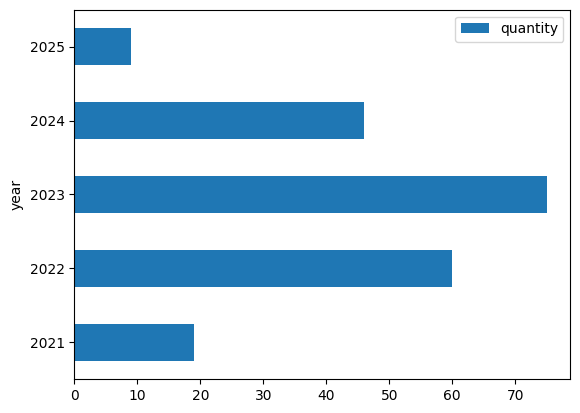

In [3147]:
df_year_count = df_an.groupby("year", as_index=False)[["month"]].count()
df_year_count = df_year.rename(columns={"month": "quantity"})
df_year_count.plot(x="year", y="quantity", kind="barh")

In [3149]:
df_date_month = df_an.groupby(["year", "month"], as_index=False)[["id_trips"]].count().rename(columns={"id_trips": "quantity"})
df_date_month.sample(n=4)

,year,month,quantity
26,2024,4,4
29,2024,8,2
21,2023,11,6
2,2021,11,10


In [3150]:
def trans_d(s):
    if isinstance(s, str) and "Водитель:" in s:
        word = s.split()[1:]
        new_word = " ".join(word)
        return new_word
    return s

def trans_t(s):
    if isinstance(s, str) and "Партнёр:" in s:
        new_word = " ".join(s.split()[1:])
        if ", ОГРН" in new_word:
            return new_word.split(", ОГРН")[0].strip()
        return new_word.strip()
    return s  

In [3151]:
df_an["color"] = df_an["auto"].apply(lambda k: k.split()[0])
df_an["car"] = df_an["auto"].apply(lambda k: k.split()[1])
df_an["car"] = df_an["car"].apply(lambda k: "Lada" if k in ["Granta", "Vesta", "Priora", "Kalina", "Largus", "XRAY"] else k)
df_an["car_model"] = df_an["auto"].apply(lambda k: k.split()[-1])

df_an = df_an.drop("auto", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [3152]:
df_an["driver"] = df_an["driver"].apply(trans_d)
df_an["transporter"] = df_an["transporter"].apply(trans_t)

In [3153]:
color, car, car_model = df_an.pop("color"), df_an.pop("car"), df_an.pop("car_model")
pos_color, pos_car, pos_car_model = df_an.columns.get_loc('driver') + 1, df_an.columns.get_loc('driver') + 2, df_an.columns.get_loc('driver') + 3
df_an.insert(pos_color, 'color', color)
df_an.insert(pos_car, 'car', car)
df_an.insert(pos_car_model, 'car_model', car_model)

In [3154]:
df_an.columns.get_loc("auto_number")

13

In [3155]:
df_an.sample(n=3)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,color,car,car_model,auto_number,transporter,telephone,date,driver_hash,in_time,year,month,day
81,1499,09:11:00,"Привокзальная улица, 1",09:23:00,"улица Богдана Хмельницкого, 117к1",UberX,111.0,Оплата,****1873,Овчаров Никита Александрович,серый,Lada,Vesta,Е683ХО21,ИП Башун Сергей Станиславович,+79991990999,2022-07-06,-6154391250227929845,12,2022,7,Wednesday
104,1522,00:14:00,улица Космонавта Андрияна Григорьевича Николае...,00:24:00,"улица Богдана Хмельницкого, 117к1",UberX,167.0,Оплата,****1873,Виссарионов Кирилл Вадимович,коричневый,Lada,Granta,Н669ЕТ790,ИП Яковлев Геннадий Васильевич,+79859927500,2022-08-19,-2959517908311662016,10,2022,8,Friday
83,1501,19:23:00,"Авиамоторная улица, 55к31",19:27:00,"Авиамоторная улица, 43/24",UberX,149.0,Оплата,****1873,Сариев Темирлан Муратбекович,жёлтый,Hyundai,Solaris,РР45377,"ООО ""АВКАРС""",+74952155459,2022-06-26,-7650563935043076496,4,2022,6,Sunday


In [3156]:
df_an_scatter = df_an.copy()

In [3170]:
df_an_scatter.sample(n=4)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,color,car,car_model,auto_number,transporter,telephone,driver_hash,in_time,year,month,day,year_month
109,1527,10:03:00,"улица Богдана Хмельницкого, 117к1",10:14:00,"проспект Максима Горького, 7",UberX,196.0,Оплата,****1873,Дмитриев Виктор Олегович,синий,Hyundai,Solaris,К092РН21,ИП Маркозов Валерий Дмитриевич,+79164850065,4009158028825781722,11,2022,8,Wednesday,2022-08
69,1487,16:18:00,"Авиамоторная улица, 55к31",16:23:00,"Авиамоторная улица, 43/24",UberX,132.0,Оплата,****1873,Недачин Александр Александрович,белый,Kia,Rio,У203ММ77,Недачин Александр Александрович,+79096540088,8408422352523462981,5,2022,5,Tuesday,2022-05
113,1531,18:52:00,"Авиамоторная улица, 55к31",18:56:00,"Авиамоторная улица, 43/24",UberX,229.0,Оплата,****3154,Демяник Максим Анатольевич,белый,Hyundai,Solaris,К087УВ799,ИП Потанина Кристина Михайловна,+79265353518,2314882913212401183,4,2021,11,Thursday,2021-11
97,1515,14:00:00,"Дубравная улица, 5к1",14:04:00,"улица Богдана Хмельницкого, 117к1",UberX,102.0,Оплата,****1873,Каменев Сергей Александрович,белый,Lada,Granta,К453РК21,ИП Шустов А.Ю,+79196787200,-2039692894353275916,4,2022,8,Saturday,2022-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


<AxesSubplot:xlabel='year_month', ylabel='cost'>

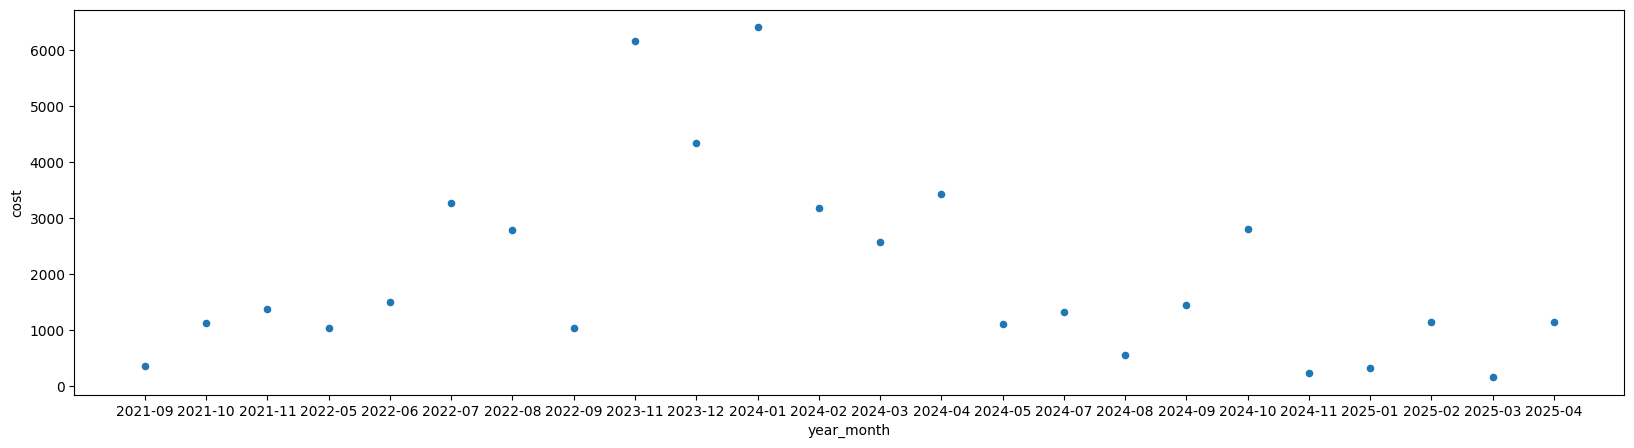

In [3161]:
df_an_scatter["year_month"] = df_an_scatter["date"].dt.to_period("M")
df_an_scatter = df_an_scatter.drop("date", 1)

x = df_an_scatter.groupby("year_month")["cost"].sum().reset_index().sort_values('year_month').query("cost > 0")
x["year_month"] = x["year_month"].astype(str)
x.plot.scatter(x="year_month", y="cost", figsize=(20, 5))

Text(0, 0.5, 'Количество поездок')

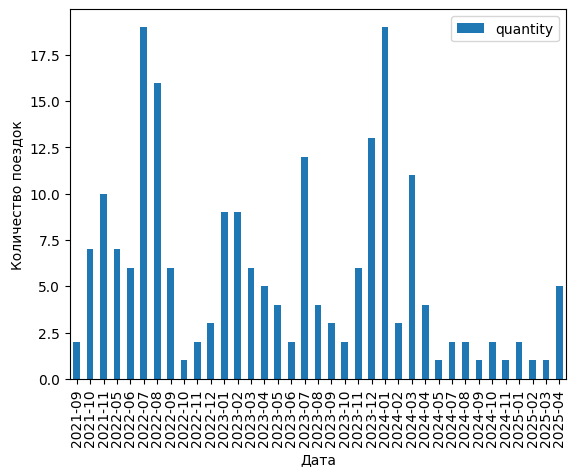

In [3179]:
df_an_scatter.groupby("year_month")["car"].count().reset_index().rename(columns={"car": "quantity"}).set_index("year_month").plot(kind="bar") # не учитваются отмененные поездки
plt.xlabel("Дата")
plt.ylabel("Количество поездок")

<AxesSubplot:xlabel='car'>

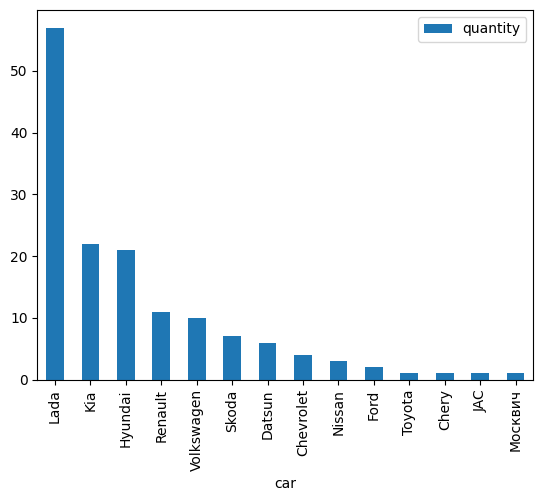

In [3212]:
df_an_scatter.groupby("car")["cost"].count().reset_index().sort_values("cost", ascending=False).query("cost > 0").rename(columns={"cost": "quantity"}).set_index("car").plot(kind="bar") # ? нужно ли учитвать отмененные поездки (здесь не взял)

In [3191]:
df_an_scatter[df_an_scatter["car"] == "Mitsubishi"]

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,color,car,car_model,auto_number,transporter,telephone,driver_hash,in_time,year,month,day,year_month
20,2886,20:16:00,"улица Богдана Хмельницкого, 117к1",20:25:00,"улица Юрия Гагарина, 30к1",UberX,NaN,NaN,NaN,NaN,белый,Opel,Astra,У204РХ163,NaN,NaN,0,9,2023,2,Thursday,2023-02


In [3225]:
df_an_scatter[df_an_scatter["tariff"] == "Select"].query("cost > 0")["car"]

127     Toyota
129        Kia
155      Skoda
192    Москвич
Name: car, dtype: object

In [3224]:
df_an_scatter[df_an_scatter["tariff"] == "Share"].query("cost > 0")["car"]

197     Kia
201    Lada
202     Kia
Name: car, dtype: object

## Ниже все тест дл df_net_poluchatel_platezha, ячейка выше все исправит 



In [2256]:
for msg_id in msg_ids:
    result, list_data = imap.fetch("1495", 'RFC822')
    msg = email.message_from_bytes(list_data[0][1])
    id_trip = msg_id.decode('utf-8')
    list_if_id_trips.append(id_trip)
    subject = base64.b64decode(msg.get("Subject").split('?')[3] + msg.get("Subject").split('?')[7]).decode('utf-8') # 'Uber — отчёт о поездке 16 марта 2024 г.'
print(subject)

Uber – отчёт о поездке 9 ав


In [2317]:
from email.header import decode_header

subject = msg.get("Subject")
decoded_parts = decode_header(subject)
subject_str = ''.join(
    part.decode(enc or 'utf-8') if isinstance(part, bytes) else part
    for part, enc in decoded_parts
)
print(subject_str)

Uber – отчёт о поездке 9 августа 2022 г.
